# AUEB M.Sc. in Data Science (part-time)

**Course**: Text Analytics

**Semester**: Spring 2018

**4th homework**: Sentiment analysis on a Twitter dataset of a large number of tweets, using RNNs with Keras (inference notebook).

**Team members**:

- Alexandros Kaplanis (https://github.com/AlexcapFF/)
- Spiros Politis
- Manos Proimakis (https://github.com/manosprom)

---

## Homework

Repeat Exercise 10 of Part 3 (text classification with MLPs), now using a bi-directional stacked RNN (with GRU or LSTM cells) and a self-attention MLP , all implemented (by you) in Keras, TensorFlow, PyTorch, or DyNet. Tune the hyper-parameters (e.g. number of stacked RNNs, number of hidden layers in the self-attention MLP) on a held-out part of the training data or using a cross-validation on the training data. You may optionally add an extra RNN layer to produce word embeddings from characters, concatenating each resulting character-based word embedding with the corresponding pre-trained (e.g. via Word2Vec) word embedding. You may optionally add a pre-trained language model (e.g., ELMo) as an extra layer to obtain context-sensitive word embeddings.

---

## Required packages and classes

In [1]:
import sys
import os
import itertools
import collections 
import pickle

import numpy as np

import sklearn.model_selection
import sklearn

import keras.preprocessing.text
import keras.preprocessing.sequence
import keras.callbacks
import keras.optimizers

import keras_tqdm

import matplotlib.pyplot as plt

# Import required classes, implemented for the assignment.
sys.path.append('src')

import utilities, preprocessing
from RNN import RNN
from FastTextEmbeddings import FastTextEmbeddings

%matplotlib inline

Using TensorFlow backend.


## Data ingestion

In [2]:
original_test_df = utilities.create_dataset(
    'data/testdata.manual.2009.06.14.csv', 
    sys.maxsize
)

## Preprocessing

In [3]:
df_test = original_test_df.copy()
df_test.drop(columns=['date', 'query', 'user'], axis = 1, inplace = True)
df_test.reset_index(drop = True, inplace = True)
df_test['text'] = df_test['text'].apply(lambda row: preprocessing.preprocess_row(row))
X_test = df_test['text'].values.tolist()
y_test = df_test['polarity'].values.tolist()

In [4]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(y_test)
y_test = le.transform(y_test)

## Creating word embeddings

### FastText embedings

In [5]:
idx = 0
vocab = {}

# Check if FastText embeddings exist on the file system...
if(not os.path.isfile('./fasttext.npy')):
    # If not, donwload and gunzip the FastText vectors file...
    if(not os.path.isfile('cc.en.300.vec')):
        if(not os.path.isfile('./cc.en.300.vec.gz')):
            !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

        !gzip -d cc.en.300.vec.gz
    
    with open("cc.en.300.vec", 'r', encoding = "utf-8", newline = '\n', errors = 'ignore') as f:
        for l in f:
            line = l.rstrip().split(' ')
            if idx == 0:
                vocab_size = int(line[0]) + 2
                dim = int(line[1])
                vecs = np.zeros(vocab_size * dim).reshape(vocab_size,dim)
                vocab["__PADDING__"] = 0
                vocab["__UNK__"] = 1
                idx = 2
            else:
                vocab[line[0]] = idx
                emb = np.array(line[1:]).astype(np.float)
                if (emb.shape[0] == dim):
                    vecs[idx, :] = emb
                    idx += 1
                else:
                    continue

        pickle.dump(vocab,open("fasttext_vocabulary",'wb'))
        
        np.save("fasttext.npy",vecs)

In [6]:
fasttext_embed = np.load("fasttext.npy")
fasttext_word_to_index = pickle.load(open("fasttext_vocabulary", "rb"))

In [7]:
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [8]:
infile = open('models/tokenizer','rb')
tokenizer = pickle.load(infile)
# tokenizer.fit_on_texts(X_train)

test_seqs = tokenizer.texts_to_sequences(X_test)
test_data = keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

### Initialize embedding matrix with fasttext pre-trained embedings

In [9]:
word_index = tokenizer.word_index
embeddings_matrix = np.zeros((MAX_WORDS + 2, EMBEDDINGS_DIM))

for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embeddings_matrix[i] = embedding_vector
    except:
        pass

## Load fitted Model

In [10]:
from keras.models import load_model
from src.LinearAttention import LinearAttention
import utilities

custom_objects={'LinearAttention': LinearAttention, 'precision': utilities.precision, 'recall': utilities.recall, 'f1': utilities.f1}
model = load_model('models/GRU_50_50_l', custom_objects=custom_objects)

W0716 20:40:44.333724 139686429488960 deprecation_wrapper.py:119] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 20:40:44.351746 139686429488960 deprecation_wrapper.py:119] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 20:40:44.353870 139686429488960 deprecation_wrapper.py:119] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 20:40:44.366046 139686429488960 deprecation_wrapper.py:119] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placehold

## Predict

In [11]:
utilities.print_evaluation(model, test_data, y_test)

y_predict_proba = model.predict(test_data)[:, 0]
y_predicted = [ 1 if proba>=0.5 else 0 for proba in y_predict_proba]

359/359 [==============================] - 1s 3ms/step

Test binary cross entropy: 0.4144

Test precision: 0.5748

Test recall: 0.5996

Test f1: nan

Test accuracy: 0.8189


In [12]:
import pandas as pd

y_true = pd.Series(y_test, name='True')
y_predicted = pd.Series(y_predicted, name='Predicted')
display(pd.crosstab(y_true, y_predicted))

Predicted,0,1
True,,
0,139,38
1,27,155


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted)) 

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       177
           1       0.80      0.85      0.83       182

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359



## Prediction Differences

In [14]:
ds_rep = utilities.get_mismatched_tweets(X_test, y_true, y_predicted)
display(ds_rep)

,actual,predicted,text
0,0,1,no i m not itchy for now maybe later lol
1,0,1,glad i didnt do bay to breakers today it s 1000 freaking degrees in san francisco wtf
2,0,1,obama administration must stop bonuses to aig ponzi schemers
3,0,1,started to think that citi is in really deep s amp t are they gonna survive the turmoil or are they gonna be the next aig
4,0,1,yahoo answers can be a butt sometimes
5,0,1,are you burning more cash than chrysler and gm stop the financial tsunami where bailout means taking a handout
6,0,1,cheney and bush are the real culprits
7,0,1,dick cheney s dishonest speech about torture terror and obama fred kaplan slate
8,0,1,night at the museum tonite instead of up oh well that 4 yr old better enjoy it lol
9,0,1,tell me again why we are giving more to gm we should use that for all the programs that support the unemployed


## Visualization of the RNN architecture

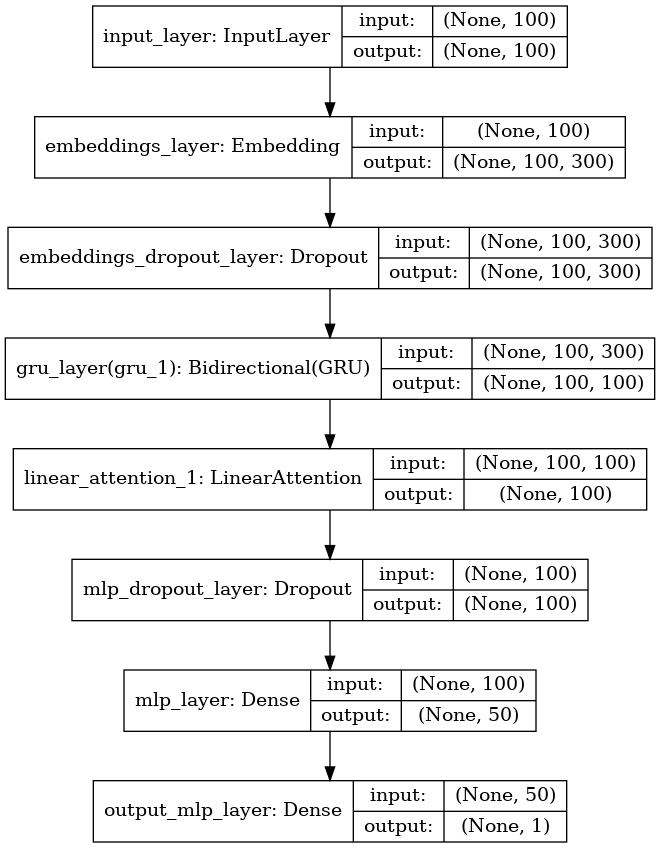

In [15]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'data/model.png')

Image(retina = True, filename = 'data/model.png')

---